# モデルフィッティング (Model Fitting)

このチュートリアルでは、`gwexpy.fitting` モジュールを使用して、時系列データ (`TimeSeries`) や周波数データ (`FrequencySeries`) に対してモデル関数のフィッティングを行う方法を学びます。

GWExPy のフィッティング機能は、バックエンドとして高機能な最小化ライブラリ `iminuit` を使用しています。
これにより、パラメータの最良推定値だけでなく、信頼性の高い**誤差評価**や**相関行列**も取得できます。

### 学ぶこと
1. **FrequencySeries のフィッティング**: べき乗則 (Power Law) モデルへの適合。
2. **TimeSeries のフィッティング**: 減衰振動 (Damped Oscillation) モデルへの適合。
3. **結果の評価**: パラメータ、誤差、プロットの確認。

## 1. FrequencySeries のフィッティング (べき乗則)

まずは、周波数スペクトルデータに対して、べき乗則モデル $y = A x^{\alpha}$ をフィッティングする例を見てみましょう。

以下のコードでは、モデル関数を定義し、ノイズを加えた模擬データを作成します。

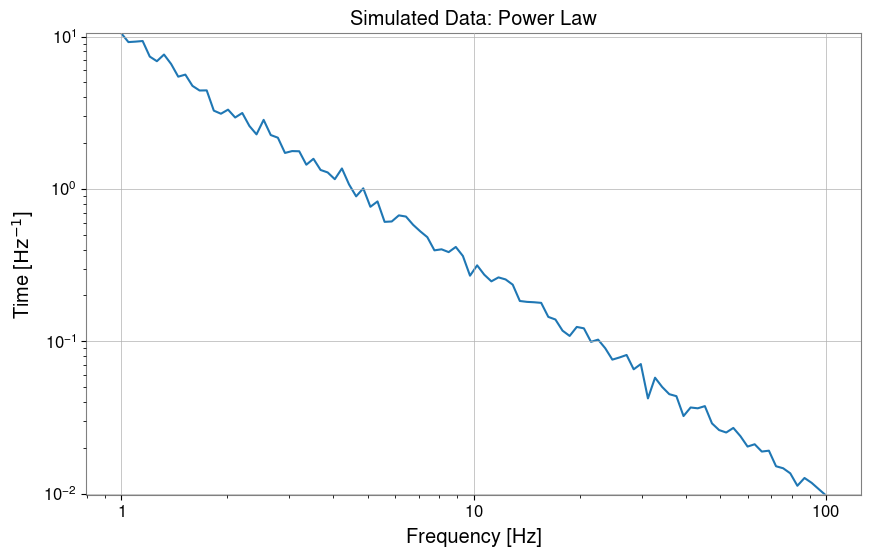

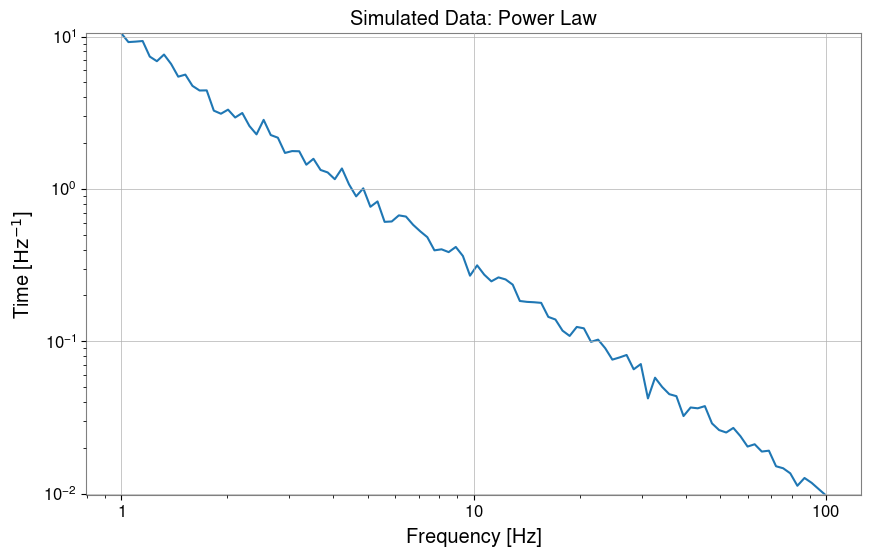

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from gwexpy.frequencyseries import FrequencySeries
from gwexpy.timeseries import TimeSeries

plt.rcParams["figure.figsize"] = (10, 6)

# モデル関数の定義: べき乗則
def power_law_model(x, A, alpha):
    return A * x ** alpha

# データの生成 (対数等間隔の周波数軸)
frequencies = np.logspace(0, 2, 100)

# 真のパラメータ
A_true = 10.0
alpha_true = -1.5

# 模擬データ: モデル値 + 10% の正規分布ノイズ
np.random.seed(42)
y_true = power_law_model(frequencies, A_true, alpha_true)
noise = 0.1 * y_true * np.random.normal(size=len(frequencies))
y_data = y_true + noise

# FrequencySeries オブジェクトの作成
fs = FrequencySeries(y_data, frequencies=frequencies, name="Noisy Power Law", unit="1/Hz")

# データの確認プロット
fs.plot(logx=True, logy=True, title="Simulated Data: Power Law")

### フィッティングの実行

`fit()` メソッドを使用してフィッティングを行います。
- 第1引数: モデル関数（または登録済みのモデル名）
- `p0`: パラメータの初期値（辞書形式）
- `sigma`: データの誤差（重み付けに使用）。ここではデータの10%を誤差として与えます。

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 89.44 (χ²/ndof = 0.9)      │              Nfcn = 89               │
│ EDM = 4.25e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬─────

/tmp/ipykernel_2051328/1418508314.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot.show()


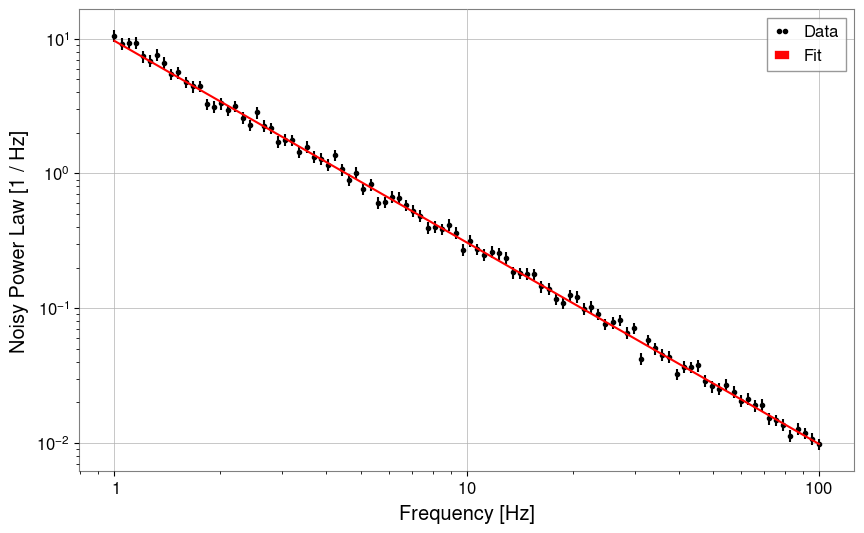

In [2]:
# フィッティング
# 初期値: A=5, alpha=-1 (真の値 A=10, alpha=-1.5 からずらしています)
result_pl = fs.fit(power_law_model,
                   p0={'A': 5, 'alpha': -1},
                   sigma=y_data * 0.1)

# 結果の表示
# パラメータの推定値、誤差、相関などが表示されます
print(result_pl)

# フィッティング結果のプロット
plot = result_pl.plot()
plot.gca().set_xscale('log')
plot.gca().set_yscale('log')
plot.show()

## 2. TimeSeries のフィッティング (減衰振動)

次に、時系列データに対して減衰振動モデル $y = A e^{-t/\tau} \cos(2\pi f t)$ をフィッティングします。

Best Fit Frequency: 10.001827885777352


/tmp/ipykernel_2051328/2639697562.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  result_osc.plot().show()


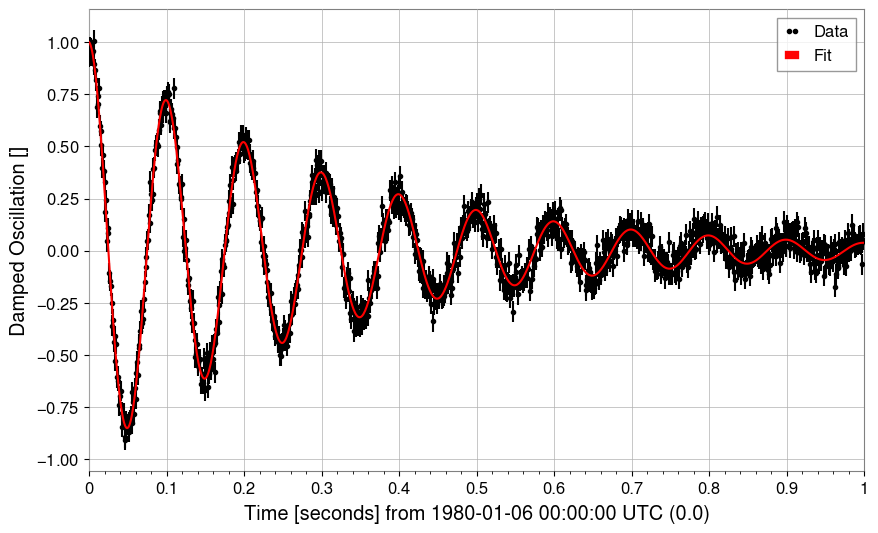

In [3]:
# モデル関数の定義: 減衰振動
def damped_osc_model(t, A, tau, f):
    return A * np.exp(-t / tau) * np.cos(2 * np.pi * f * t)

# データの生成
t = np.linspace(0, 1, 1000)

# 真のパラメータ
A_true = 1.0
tau_true = 0.3
f_true = 10.0

# 模擬データ: モデル値 + 一定のノイズ
y_osc_data = damped_osc_model(t, A_true, tau_true, f_true) + 0.05 * np.random.normal(size=len(t))

# TimeSeries オブジェクトの作成
ts = TimeSeries(y_osc_data, times=t, name="Damped Oscillation")

# フィッティングの実行
# p0: 初期値
# sigma: ノイズレベル (一定)
result_osc = ts.fit(damped_osc_model,
                    p0={'A': 0.5, 'tau': 0.5, 'f': 12},
                    sigma=0.05)

# 結果の表示
print("Best Fit Frequency:", result_osc.params['f'])
display(result_osc)

# プロット
result_osc.plot().show()

## まとめ

- `gwexpy` の `TimeSeries` や `FrequencySeries` は `.fit()` メソッドを直接持っており、簡単にモデルフィッティングが行えます。
- Python 関数として定義した任意のモデルを使用可能です。
- 結果はリッチなテーブル形式で表示され、プロットメソッドで視覚的な確認も容易です。